# COMBO の基本

## はじめに

ベイズ最適化は、複雑なシミュレーションや、実世界における実験タスクなど、目的関数の評価に大きなコストがかかるような最適化問題に適しています。

本チュートリアルでは例として、Cu の安定した界面構造の探索問題を扱います。  
目的関数の評価にあたる構造緩和計算には、実際には1回あたり数時間といったオーダーの時間を要しますが、
本チュートリアルでは既に評価済みの値を使用します。

問題設定については、以下の文献を参照してください。

- S. Kiyohara, H. Oda, K. Tsuda and T. Mizoguchi, “Acceleration of stable interface structure searching using a kriging approach”, Jpn. J. Appl. Phys. 55, 045502 (2016).

COMBO では以下の手順により最適化を実行します。

- 探索候補データの準備
- simulator の定義
- 最適化の実行
- 結果の確認

---

それではサンプルデータを用いて、各手順を実際に行ってみましょう。

はじめに、COMBO をインポートします。

In [1]:
import combo

## 探索候補データの準備

まず、以下を実行してサンプルデータをダウンロードしてください。

In [2]:
import os
import urllib
import ssl
import numpy as np

ssl._create_default_https_context = ssl._create_unverified_context

def download():
    if not os.path.exists('data/s5-210.csv'):

        if not os.path.exists('data'):
            os.mkdir('data')
            
        print('Downloading...')
        with urllib.request.urlopen("http://www.tsudalab.org/files/s5-210.csv") as response, open('data/s5-210.csv', 'wb') as out_file:
            out_file.write(response.read())
        print('Done')
        
def load_data():
    download()
    A =  np.asarray(np.loadtxt('data/s5-210.csv',skiprows=1,delimiter=',') )
    X = A[:,0:3]
    t  = -A[:,3]
    return X, t

In [3]:
X, t = load_data()

以下、N: 探索候補の数  , d: 入力パラメータの次元数  とします。

X は N x d 次元の行列で、各行は探索候補である各パラメータセット (d 次元のベクトル) を表します。  
t は N 次元のベクトルで、各探索候補の負のエネルギー(最適化したい目的関数の値) と対応します。  

**COMBO では最適化の方向は「最大化」だと仮定します。**  

元々の問題設定は「エネルギー最小化」ですが、COMBOで最適化を行うにあたって、目的関数値にマイナスを掛けて「負のエネルギーの最大化」問題として扱っています。

t は実際には不明ですが、ここでは既に取得された値を利用します。  

In [4]:
X

array([[ 0. ,  1. ,  0. ],
       [ 0. ,  1. ,  0.1],
       [ 0. ,  1. ,  0.2],
       ..., 
       [ 8. ,  1.5,  3.4],
       [ 8. ,  1.5,  3.5],
       [ 8. ,  1.5,  3.6]])

In [5]:
t

array([-1.01301176, -1.01487066, -1.02044168, ..., -1.11680203,
       -2.48876352, -2.4971452 ])

探索パラメータのスケールを合わせるため、X の各列についてそれぞれ、平均が0, 分散が 1 となるよう標準化します。

In [6]:
X = combo.misc.centering( X )

In [7]:
X

array([[-1.71079785, -1.46385011, -1.68585446],
       [-1.71079785, -1.46385011, -1.59219588],
       [-1.71079785, -1.46385011, -1.4985373 ],
       ..., 
       [ 1.71079785,  1.46385011,  1.4985373 ],
       [ 1.71079785,  1.46385011,  1.59219588],
       [ 1.71079785,  1.46385011,  1.68585446]])

## simulator の定義

COMBO に与える simulator クラスを定義します。  
`__call__` メソッドの返り値が、action を与えたときの目的関数値となります。  
action は探索候補の ID (0, 1, ..., N-1) を表します。

本チュートリアルでは、action が与えられたときに、既に計算された t の値をそのまま返すだけの simulator を定義しています。  
他の問題に適用する際は、simulator クラスをカスタマイズしてください。

In [8]:
class simulator:
    def __init__( self ):
        _, self.t = load_data()
    
    def __call__( self, action ):
        return self.t[action]

## 最適化の実行

### policy のセット

まず、最適化の policy をセットします。  

`test_X` に探索候補の行列 (numpy.array) を指定します。

In [9]:
# policy のセット 
policy = combo.search.discrete.policy(test_X=X)

# シード値のセット 
policy.set_seed(0)

policy をセットした段階では、まだ最適化は行われません。
policy に対して以下のメソッドを実行することで、最適化を行います。

- `random_search`  
- `bayes_search`

これらのメソッドに先ほど定義した simulator と探索ステップ数を指定すると、探索ステップ数だけ以下のループが回ります。

1. パラメータ候補の中から次に実行するパラメータを選択
2. 選択されたパラメータで simulator を実行

1で返されるパラメータはデフォルトでは1つですが、1ステップで複数のパラメータを返すことも可能です。
詳しくは「複数候補を一度に探索する」の項目を参照してください。  

また、上記のループを COMBO の中で回すのではなく、1 と 2 を別個に外部から制御することも可能です。つまり、COMBO から次に実行するパラメータを推薦してもらい、それをCOMBOの外部で何らかの形で評価し、評価値をCOMBOに登録する、という手順が可能です。  
詳しくは「インタラクティブに実行する」の項目を参照してください。

### ランダムサーチ

まず初めに、ランダムサーチを行ってみましょう。

ベイズ最適化の実行には、目的関数値が1つ以上求まっている必要があるため、まずランダムサーチを実行します。   

**引数**  

- `max_num_probes`: 探索ステップ数  
- `simulator`: 目的関数のシミュレータ (simulator クラスのオブジェクト) 

In [10]:
res = policy.random_search(max_num_probes=20, simulator=simulator())

0001-th step: f(x) = -1.070602 (action=15673)
   current best f(x) = -1.070602 (best action=15673) 

0002-th step: f(x) = -1.153410 (action=16489)
   current best f(x) = -1.070602 (best action=15673) 

0003-th step: f(x) = -0.981899 (action=7792)
   current best f(x) = -0.981899 (best action=7792) 

0004-th step: f(x) = -1.066080 (action=13752)
   current best f(x) = -0.981899 (best action=7792) 

0005-th step: f(x) = -1.043272 (action=9023)
   current best f(x) = -0.981899 (best action=7792) 

0006-th step: f(x) = -1.125822 (action=1470)
   current best f(x) = -0.981899 (best action=7792) 

0007-th step: f(x) = -1.070720 (action=14404)
   current best f(x) = -0.981899 (best action=7792) 

0008-th step: f(x) = -1.091624 (action=14031)
   current best f(x) = -0.981899 (best action=7792) 

0009-th step: f(x) = -0.963795 (action=5734)
   current best f(x) = -0.963795 (best action=5734) 

0010-th step: f(x) = -0.989538 (action=3111)
   current best f(x) = -0.963795 (best action=5734) 

001

実行すると、各ステップの目的関数値とその action ID、現在までのベスト値とその action ID が出力されます。  

### ベイズ最適化

続いて、ベイズ最適化を以下のように実行します。

**引数**  

- `max_num_probes`: 探索数  
- `simulator`: 目的関数のシミュレータ (simulator クラスのオブジェクト)  
- `score`: 獲得関数(acquisition function) のタイプ。以下のいずれかを指定  
    - TS (Thompson Sampling)  
    - EI (Expected Improvement)  
    - PI (Probability of Improvement)  
- `interval`:  
指定したインターバルごとに、ハイパーパラメータを学習する。  
負の値を指定すると、ハイパーパラメータの学習は行われない。  
0 を指定すると、ハイパーパラメータの学習は最初のステップでのみ行われる。  
- `num_rand_basis`: 基底関数の数。0を指定すると、通常のガウス過程が使用される。  

In [11]:
res = policy.bayes_search(max_num_probes=80, simulator=simulator(), score='TS', 
                                                  interval=20, num_rand_basis=5000)

Start the initial hyper parameter searching ...
Done

Start the hyper parameter learning ...
0-th epoch, marginal likelihood -26.9250995475
50-th epoch, marginal likelihood -28.1169001493
100-th epoch, marginal likelihood -28.7170482808
150-th epoch, marginal likelihood -29.0372406445
200-th epoch, marginal likelihood -29.243814308
250-th epoch, marginal likelihood -29.4049905275
300-th epoch, marginal likelihood -29.5433750628
350-th epoch, marginal likelihood -29.6643378856
400-th epoch, marginal likelihood -29.768631164
450-th epoch, marginal likelihood -29.8566967846
500-th epoch, marginal likelihood -29.9296129084
Done

 Parameters of Gaussian kernel 
 
 width  =  [ 3.]
 scale  =  1.0
 scale2 =  1.0
 

0021-th step: f(x) = -1.071398 (action=399)
   current best f(x) = -0.963795 (best action=5734) 

0022-th step: f(x) = -1.014235 (action=10613)
   current best f(x) = -0.963795 (best action=5734) 

0023-th step: f(x) = -0.964418 (action=5068)
   current best f(x) = -0.963795 (best a

Done

Start the hyper parameter learning ...
0-th epoch, marginal likelihood 192.770783806
50-th epoch, marginal likelihood 137.498597682
100-th epoch, marginal likelihood 101.543059137
150-th epoch, marginal likelihood 78.0899896626
200-th epoch, marginal likelihood 57.8944428172
250-th epoch, marginal likelihood 42.2793019848
300-th epoch, marginal likelihood 31.7391591755
350-th epoch, marginal likelihood 24.9122758997
400-th epoch, marginal likelihood 18.2672049609
450-th epoch, marginal likelihood 12.4853943861
500-th epoch, marginal likelihood 8.35574904395
Done

 Parameters of Gaussian kernel 
 
 width  =  [ 0.84606992]
 scale  =  0.347130092099
 scale2 =  0.12049930084
 

0081-th step: f(x) = -1.123209 (action=17976)
   current best f(x) = -0.963795 (best action=5734) 

0082-th step: f(x) = -1.137505 (action=15992)
   current best f(x) = -0.963795 (best action=5734) 

0083-th step: f(x) = -1.081899 (action=17907)
   current best f(x) = -0.963795 (best action=5734) 

0084-th ste

## 結果の確認

探索結果 res は history クラスのオブジェクト (`combo.search.discrete.results.history`) として返されます。  
以下より探索結果を参照します。

- `res.fx` : simulator (目的関数) の評価値の履歴
- `res.chosed_actions`: simulator を評価したときの action ID の履歴  
- `fbest, best_action= res.export_all_sequence_best_fx()`: simulator を評価した全タイミングにおけるベスト値とその action ID の履歴  
- `res.total_num_search`: simulator のトータル評価数  

各ステップでの目的関数値と、ベスト値の推移をプロットしてみましょう。  
`res.fx`, `best_fx` はそれぞれ `res.total_num_search` までの範囲を指定します。

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

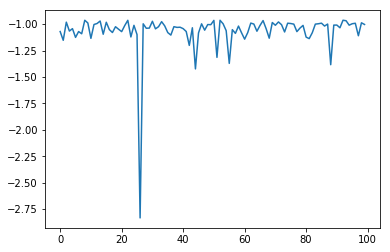

In [13]:
plt.plot(res.fx[0:res.total_num_search])

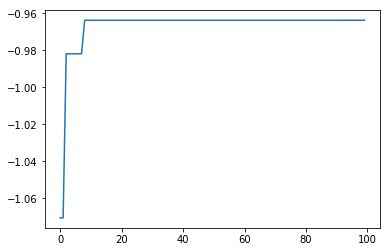

In [14]:
best_fx, best_action = res.export_all_sequence_best_fx()
plt.plot(best_fx)

## 結果のシリアライズ

探索結果は `save` メソッドにより外部ファイルに保存できます。

In [15]:
res.save('test.npz')

In [16]:
del res

保存した結果ファイルは以下のようにロードします。

In [17]:
res = combo.search.discrete.results.history()
res.load('test.npz')